# Generating Player-Based Tables from LiveSum Data

## Part 0: Importing all necessary libraries

In [1]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
from openai import OpenAI

## Part 1: Preprocessing the Data for use

### Part 1a. Loading Training and Test Data from the JSON Files

In [2]:
with open('train.json') as f:
    train_data = json.load(f)
train_df = pd.json_normalize(train_data)
with open('test.json') as f:
    test_data = json.load(f)
test_df = pd.json_normalize(test_data)

#display the first few rows of the dataframes
display(train_df.head())
display(test_df.head())

,text,table,id
0,And we're off for the start of the first half....,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513261
1,"And we're off, the First Half has kicked off. ...","Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513267
2,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513268
3,And we're underway in the first half. Player9(...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513270
4,The game is starting with the first half. Play...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513272


,text,table,id
0,And we're off for the first half. Player27(Awa...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513332
1,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513360
2,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25600389
3,And we're off for the first half. Player26(Awa...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25617902
4,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25892175


### Part 1b. Use the first Training Row to see if we can generate some player-based stats tables

In [3]:
train_row_1 = train_df.iloc[0]
train_comm = train_row_1['text']
print(train_comm)

And we're off for the start of the first half. Player10(Home Team) commits a foul on Player23(Away Team), resulting in a free kick awarded in the defensive half. Player8(Home Team) commits a foul. Player20(Away Team) earns a free kick on the right side of the field. Player26(Away Team) misses the header from the center of the box, it goes high and wide to the right, Player28(Away Team) assisted with a cross after a set piece. The Away Team wins a corner kick. Player2(Home Team) earns a free kick on the right side of the field. Player24(Away Team) commits a foul. Player6(Home Team) misses the goal with a shot from the center of the box, assisted by Player5(Home Team)'s cross. Player24(Away Team) commits a foul, resulting in Player9(Home Team) being awarded a free kick in the attacking half, This leads to a set-piece opportunity for Player9(Home Team)'s team. Player8(Home Team)'s attempt from outside the box on a direct free kick is just a little too high. Player7(Home Team) commits a fo

In [4]:
#Making it a bit more readable
commentary = train_comm.replace('. ', '.\n')
print(commentary)


And we're off for the start of the first half.
Player10(Home Team) commits a foul on Player23(Away Team), resulting in a free kick awarded in the defensive half.
Player8(Home Team) commits a foul.
Player20(Away Team) earns a free kick on the right side of the field.
Player26(Away Team) misses the header from the center of the box, it goes high and wide to the right, Player28(Away Team) assisted with a cross after a set piece.
The Away Team wins a corner kick.
Player2(Home Team) earns a free kick on the right side of the field.
Player24(Away Team) commits a foul.
Player6(Home Team) misses the goal with a shot from the center of the box, assisted by Player5(Home Team)'s cross.
Player24(Away Team) commits a foul, resulting in Player9(Home Team) being awarded a free kick in the attacking half, This leads to a set-piece opportunity for Player9(Home Team)'s team.
Player8(Home Team)'s attempt from outside the box on a direct free kick is just a little too high.
Player7(Home Team) commits a fo

### Part 1c. Attempt to extract the Players involved into two separate DataFrames

In [5]:
# Verify the content of the commentary variable
print(commentary)

# Adjust the regex pattern if necessary to match the actual format of the commentary
def extract_team_events(commentary, team_type):
    pattern = rf"Player\d+\s*\({team_type} Team\).*?"
    matches = re.findall(pattern, commentary)
    events = []
    for match in matches:
        player_match = re.search(r"Player\d+", match)
        if player_match:
            player = player_match.group()
            event = match.replace(player, "").strip()
            events.append({"Player": player, "Event": event})
    return pd.DataFrame(events)

# Recreate the DataFrames for home and away teams
home_team_df = extract_team_events(commentary, "Home")
away_team_df = extract_team_events(commentary, "Away")


And we're off for the start of the first half.
Player10(Home Team) commits a foul on Player23(Away Team), resulting in a free kick awarded in the defensive half.
Player8(Home Team) commits a foul.
Player20(Away Team) earns a free kick on the right side of the field.
Player26(Away Team) misses the header from the center of the box, it goes high and wide to the right, Player28(Away Team) assisted with a cross after a set piece.
The Away Team wins a corner kick.
Player2(Home Team) earns a free kick on the right side of the field.
Player24(Away Team) commits a foul.
Player6(Home Team) misses the goal with a shot from the center of the box, assisted by Player5(Home Team)'s cross.
Player24(Away Team) commits a foul, resulting in Player9(Home Team) being awarded a free kick in the attacking half, This leads to a set-piece opportunity for Player9(Home Team)'s team.
Player8(Home Team)'s attempt from outside the box on a direct free kick is just a little too high.
Player7(Home Team) commits a fo

In [6]:
display(home_team_df)

,Player,Event
0,Player10,(Home Team)
1,Player8,(Home Team)
2,Player2,(Home Team)
3,Player6,(Home Team)
4,Player5,(Home Team)
5,Player9,(Home Team)
6,Player9,(Home Team)
7,Player8,(Home Team)
8,Player7,(Home Team)
9,Player7,(Home Team)


In [7]:
display(away_team_df)

,Player,Event
0,Player23,(Away Team)
1,Player20,(Away Team)
2,Player26,(Away Team)
3,Player28,(Away Team)
4,Player24,(Away Team)
5,Player24,(Away Team)
6,Player23,(Away Team)
7,Player22,(Away Team)
8,Player24,(Away Team)
9,Player22,(Away Team)


### Part 1d. With the players extracted, now we try to add the stats (Shots, Fouls, Yellow Cards, Red Cards, FK, SOG, Shot Accuracy, etc.) by querying an LLM

In [8]:
# Assuming you have a function to get the player names and events

In [14]:
prompt = f"""
According to the live text, please count for each player, splitting players by team, the number of: 
1. goals, 
2. shots, 
3. fouls, 
4. yellow cards, 
5. red cards, 
6. Assists, 
7. free kicks, 
8. offsides 
Note that goals, saved attempts, blocked attempts, and missed attempts are considered shots. 
Handball and dangerous play are also considered fouls. 
The second yellow card is also considered a red card.
Penalty is also considered as a free kick.

Format the output as two separate tables:
1. One table for the Home Team and one for the Away Team.
2. Use "|" as a separator between cells.
3. Use the literal "<NEWLINE>" to mark the end of each row.
4. Each table should start with a header row that includes: 
| Player | Goals | Shots Taken | Free Kicks | Assists | Fouls | Yellow Cards | Red Cards | Offsides | <NEWLINE>
5. Prefix each table with a heading:
    ### Final Table (Home Team):
    ### Final Table (Away Team):
6. Include player names as PlayerX(Team Name) (e.g., Player10(Home Team))
7. Show the stats for all players in the commentary, even if they have zero stats.
8. If a player has no stats, show "0" for all columns except Player.
Let’s think step by step! Return the reasoning steps and at last, please output two tables in the specified CSV format according to the following live text:
{commentary}.
Precede the tables with the line "Now let's format this into the required tables." before outputting the tables.
"""
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        }
    ],
    max_tokens=3000,
)

print(response.choices[0].message.content)

To derive the statistics for each player from the commentary, I will analyze the text step by step, focusing on the designated statistics: goals, shots, fouls, yellow cards, red cards, assists, free kicks, and offsides. 

### Step-by-step Analysis:
1. **Goals**: 
   - Player26(Away Team) scored 1 goal.
   - Player6(Home Team) scored 1 goal (penalty).

2. **Shots**: 
   - Every goal is a shot, so Player26(Away Team) has 1 shot for his goal.
   - Player6(Home Team) has 1 shot for his goal (penalty), and additionally—Player7, Player10, Player6, and others had shots that were blocked or missed, which count as shots taken. 
   - Count all missed, saved, and blocked attempts as shots.

3. **Fouls**:
   - There are multiple fouls by both teams, noted specifically in the commentary. Player10, Player7, Player8, Player14 from Home Team and Player24, Player22, Player25, Player26, Player28, Player27 from Away Team committed fouls. 

4. **Yellow Cards**:
   - Player7 and Player11 from Home Team rec

In [15]:
#Display the Tables as Dataframes for readability
from io import StringIO
home_team_table = """
| Player | Goals | Shots Taken | Free Kicks | Assists | Fouls | Yellow Cards | Red Cards | Offsides | <NEWLINE>
| Player10(Home Team) | 0 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player8(Home Team) | 0 | 1 | 2 | 0 | 2 | 1 | 0 | 0 | <NEWLINE>
| Player6(Home Team) | 1 | 4 | 1 | 1 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player5(Home Team) | 0 | 1 | 0 | 1 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player7(Home Team) | 0 | 2 | 0 | 0 | 3 | 1 | 0 | 0 | <NEWLINE>
| Player9(Home Team) | 0 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player2(Home Team) | 0 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player11(Home Team) | 0 | 0 | 1 | 0 | 1 | 1 | 0 | 0 | <NEWLINE>
| Player3(Home Team) | 0 | 0 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player4(Home Team) | 0 | 0 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player14(Home Team) | 0 | 0 | 0 | 0 | 2 | 0 | 0 | 0 | <NEWLINE>

"""
away_team_table = """
| Player | Goals | Shots Taken | Free Kicks | Assists | Fouls | Yellow Cards | Red Cards | Offsides | <NEWLINE>
| Player26(Away Team) | 1 | 2 | 1 | 1 | 1 | 0 | 0 | 1 | <NEWLINE>
| Player28(Away Team) | 0 | 0 | 2 | 0 | 1 | 1 | 0 | 0 | <NEWLINE>
| Player20(Away Team) | 0 | 0 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player22(Away Team) | 0 | 1 | 0 | 1 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player25(Away Team) | 0 | 1 | 0 | 0 | 2 | 2 | 1 | 0 | <NEWLINE>
| Player27(Away Team) | 0 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player29(Away Team) | 0 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | <NEWLINE>
| Player24(Away Team) | 0 | 0 | 0 | 0 | 2 | 0 | 0 | 0 | <NEWLINE>
| Player23(Away Team) | 0 | 0 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
| Player33(Away Team) | 0 | 0 | 1 | 0 | 1 | 0 | 0 | 0 | <NEWLINE>
"""

home_team_raw = home_team_table.strip()
away_team_raw = away_team_table.strip()
# Function to convert the GPT table format to a DataFrame
def gpt_table_to_df(raw_text):
    # Step 1: Replace <NEWLINE> with actual newlines
    cleaned = raw_text.replace("<NEWLINE>", "\n").strip()
    
    # Step 2: Remove pipes from the start/end of each line and strip spaces
    lines = [line.strip().strip("|").strip() for line in cleaned.splitlines()]
    
    # Step 3: Reconstruct into a CSV-like string
    csv_like = "\n".join([",".join(cell.strip() for cell in line.split("|")) for line in lines])
    
    # Step 4: Read with pandas
    return pd.read_csv(StringIO(csv_like))

# Convert
home_df = gpt_table_to_df(home_team_raw)
away_df = gpt_table_to_df(away_team_raw)

# Done! Now you can use:
display(home_df)
display(away_df)


,Player,Goals,Shots Taken,Free Kicks,Assists,Fouls,Yellow Cards,Red Cards,Offsides
0,Player10(Home Team),0,1,1,0,1,0,0,0
1,Player8(Home Team),0,1,2,0,2,1,0,0
2,Player6(Home Team),1,4,1,1,1,0,0,0
3,Player5(Home Team),0,1,0,1,1,0,0,0
4,Player7(Home Team),0,2,0,0,3,1,0,0
5,Player9(Home Team),0,1,1,0,1,0,0,0
6,Player2(Home Team),0,1,1,0,1,0,0,0
7,Player11(Home Team),0,0,1,0,1,1,0,0
8,Player3(Home Team),0,0,1,0,1,0,0,0
9,Player4(Home Team),0,0,1,0,1,0,0,0


,Player,Goals,Shots Taken,Free Kicks,Assists,Fouls,Yellow Cards,Red Cards,Offsides
0,Player26(Away Team),1,2,1,1,1,0,0,1
1,Player28(Away Team),0,0,2,0,1,1,0,0
2,Player20(Away Team),0,0,1,0,1,0,0,0
3,Player22(Away Team),0,1,0,1,1,0,0,0
4,Player25(Away Team),0,1,0,0,2,2,1,0
5,Player27(Away Team),0,1,1,0,1,0,0,0
6,Player29(Away Team),0,1,0,1,0,0,0,0
7,Player24(Away Team),0,0,0,0,2,0,0,0
8,Player23(Away Team),0,0,1,0,1,0,0,0
9,Player33(Away Team),0,0,1,0,1,0,0,0


### Part 1e. Extract the 'tables' from the row to find out what the stats should be

In [11]:
# Extract the table string from the first row of train_df
table_string = train_df.iloc[0]['table']

# Split the table string into rows
table_rows = table_string.split('<NEWLINE>')

# Extract the header and data rows
header = table_rows[0].split(',')
data = [row.split(',') for row in table_rows[1:]]

# Create a pandas DataFrame
table_df = pd.DataFrame(data, columns=header)


# Display the DataFrame
display(table_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Corner Kicks,Free Kicks,Offsides
0,Away Team,1,8,10,3,0,4,12,1
1,Home Team,1,13,12,2,0,9,10,0


### Part 1f. Display the two Player-wise Statistics Tables to show the data collected

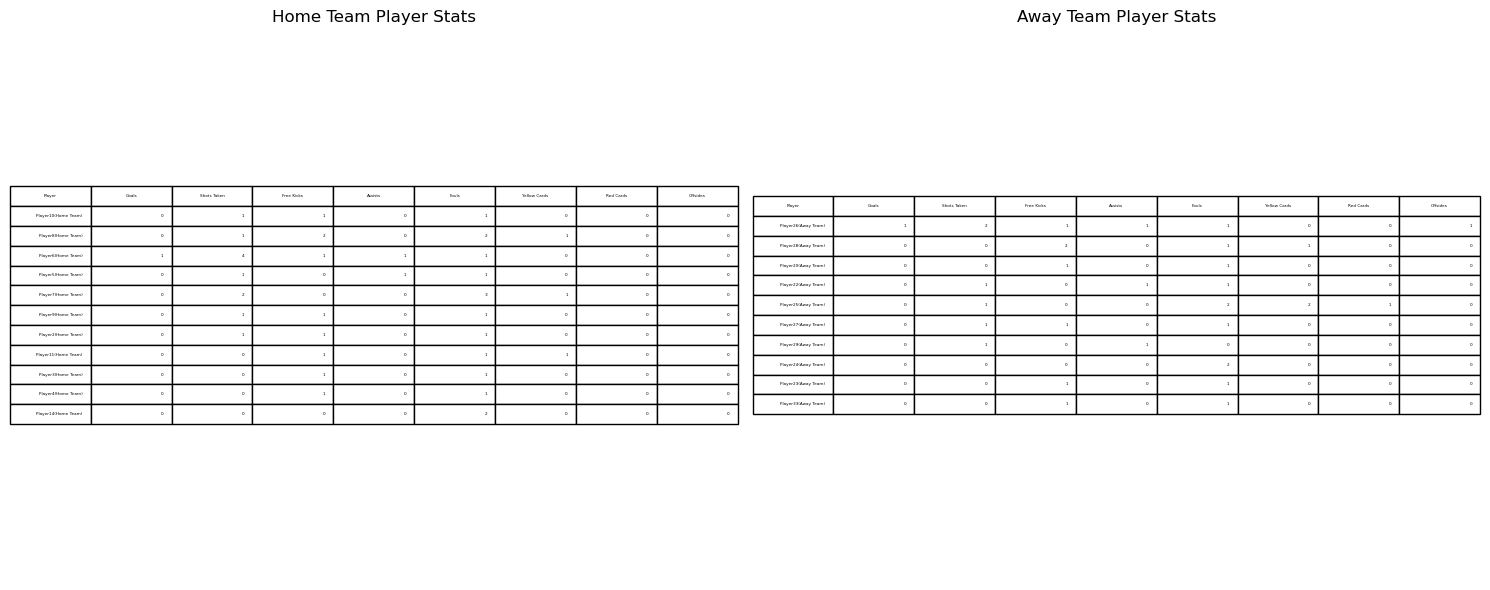

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot home team stats
axes[0].axis('tight')
axes[0].axis('off')
axes[0].table(cellText=home_df.values, colLabels=home_df.columns, loc='center')
axes[0].set_title('Home Team Player Stats')

# Plot away team stats
axes[1].axis('tight')
axes[1].axis('off')
axes[1].table(cellText=away_df.values, colLabels=away_df.columns, loc='center')
axes[1].set_title('Away Team Player Stats')

plt.tight_layout()
plt.show()

# Part 2: Fixing the LLM's Errors


## Part 2a. Totaling up Home/Away stats to see how far from correct we are

In [19]:
# Calculate column-wise sums for home and away dataframes
home_team_stats = home_df.iloc[:, 1:].sum()
away_team_stats = away_df.iloc[:, 1:].sum()

# Create a new dataframe for team-wise stats
team_stats = pd.DataFrame({
    'Team': ['Home Team', 'Away Team'],
    'Goals': [home_team_stats['Goals'], away_team_stats['Goals']],
    'Shots': [home_team_stats['Shots Taken'], away_team_stats['Shots Taken']],
    'Fouls': [home_team_stats['Fouls'], away_team_stats['Fouls']],
    'Yellow Cards': [home_team_stats['Yellow Cards'], away_team_stats['Yellow Cards']],
    'Red Cards': [home_team_stats['Red Cards'], away_team_stats['Red Cards']],
    'Free Kicks': [home_team_stats['Free Kicks'], away_team_stats['Free Kicks']],
    'Offsides': [home_team_stats['Offsides'], away_team_stats['Offsides']]
})
# Invert the rows to match the format of the ground truth table
team_stats = team_stats.iloc[::-1].reset_index(drop=True)
# Display the team-wise stats
display(team_stats)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Free Kicks,Offsides
0,Away Team,1,6,11,3,1,7,1
1,Home Team,1,11,15,3,0,9,0


In [20]:
# Drop the 'Corner Kicks' column from table_df
table_df = table_df.drop(columns=['Corner Kicks'])

# Display the updated DataFrame
display(table_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Free Kicks,Offsides
0,Away Team,1,8,10,3,0,12,1
1,Home Team,1,13,12,2,0,10,0


In [22]:
# Calculate the differences between `table_df` and `team_stats`
difference_df = table_df.set_index('Team').astype(int) - team_stats.set_index('Team')

# Reset the index for better readability
difference_df.reset_index(inplace=True)

# Display the resulting DataFrame
display(difference_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Free Kicks,Offsides
0,Away Team,0,2,-1,0,-1,5,0
1,Home Team,0,2,-3,-1,0,1,0


## Part 2b. Now that we have a measure of the LLM's inaccuracies, now we attempt to fix it...
##          ...using the LLM itself